# Tensorflow MNIST Classifier demo

This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop.
Please see the [example README](README.md) for instructions on how to prepare your environment for running this example.

## Initial Setup

### Setup the Python client and Login to the Dioptra deployment

To connect with the endpoint, we will use a client class defined in the `examples/scripts/client.py` file that is able to connect with the Dioptra RESTful API using the HTTP protocol.
We connect using the client below.
The client uses the environment variable `DIOPTRA_RESTAPI_URI`, which we configured at the top of the notebook, to figure out how to connect to the Dioptra RESTful API.

It is necessary to login to the RESTAPI to be able to perform any functions. Here we create a user if it is not created already, and login with it.

In [1]:
from dioptra.client import connect_json_dioptra_client

DIOPTRA_REST_API_ADDRESS = "http://localhost"
DIOPTRA_REST_API_USER = "keith"
DIOPTRA_REST_API_PASS = "pass"

client = connect_json_dioptra_client(DIOPTRA_REST_API_ADDRESS)

# if you have not yet registered a user, uncomment the following line and adjust the parameters as desired to register a user first
# client.users.create(DIOPTRA_REST_API_USER, email=f"{DIOPTRA_REST_API_USER}@localhost", password=DIOPTRA_REST_API_PASS)

client.auth.login(DIOPTRA_REST_API_USER, DIOPTRA_REST_API_PASS)

{'username': 'keith', 'status': 'Login successful'}

### Import libraries and define helper functions

Below we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

This is a helper function to retrieve artifact IDs from dioptra by name for a given job. In this notebook it will be used to retrieve adversarial and defended datasets, as well as the model. In the future, it may not be used for the model, as that functionality receives more specific support in Dioptra.

In [2]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import structlog
import time
import warnings

from IPython.display import display, clear_output
from pathlib import Path
from pprint import pprint
from tempfile import TemporaryDirectory
from typing import Any
from dioptra.client import select_files_in_directory


# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

def wait_for_job(job, quiet=False):
    n = 0
    while job['status'] not in ['finished', 'failed']:
        job = client.jobs.get_by_id(job['id'])
        time.sleep(1)
        if not quiet:
            clear_output(wait=True)
            display("Waiting for job to finish" + "." * (n % 3) )
        n += 1
    if not quiet:
        if job['status'] == 'finished':
            clear_output(wait=True)
            display(f'Job finished.')
        else:
            display("Job failed. Please see job logs for details.")
    return job

def find_artifact_by_name(artifact_name: str, job: dict[str, Any]) -> dict[str, Any]:
    for job_artifact in job["artifacts"]:
        artifact = client.artifacts.get_by_id(job_artifact["id"])
        if artifact_name in artifact["description"]:
            return {
                "id": artifact["id"],
                "snapshotId": artifact["snapshot"],
            }
    raise Exception("Could not retrieve artifact")

def load_image_from_artifact(artifact, path):
    with TemporaryDirectory() as t:
        local_path = client.artifacts.get_contents(artifact["id"], artifact_path=path, output_dir=t, file_stem="tmp.png")
        return plt.imread(local_path)

def get_metrics(job):
    return {m["name"]: m["value"] for m in client.jobs.get_metrics_by_id(job_id=job["id"])}

def display_sample_images(artifact):
    paths = [f["relativePath"] for f in client.artifacts.get_files(artifact["id"])]
    for idx, path in enumerate(paths[:9]):
        sample = load_image_from_artifact(artifact, paths[idx])
        plt.subplot(3, 3, idx+1)
        plt.imshow(sample, cmap="gray")

def display_training_stats(job):
    epochs = int(job["values"]["epochs"])
    metrics = get_metrics(jobs["train"])
    loss = client.jobs.get_metrics_snapshots_by_id(job_id=job["id"], metric_name="loss")
    accuracy = client.jobs.get_metrics_snapshots_by_id(job_id=job["id"], metric_name="categorical_accuracy")
    plt.plot([m["value"] for m in loss["data"]], color="green", label="val_loss")
    plt.plot([m["value"] for m in accuracy["data"]], color="blue", label="val_accuracy")
    plt.hlines(metrics["test_categorical_accuracy"], xmin=0, xmax=epochs-1, linestyles="dashed", color="blue", label="test_accuracy")
    plt.title(job["description"])
    plt.xlabel("epoch")
    plt.xticks(list(range(epochs)))
    plt.legend()

def display_metrics(metrics, metric: str):
    metrics = sorted(metrics.items())
    plt.bar([m[0] for m in metrics], [m[1][metric] for m in metrics])
    plt.xticks(rotation=45)
    plt.title(metric)

### Setup dataset

We obtained a copy of the MNIST dataset when we ran `download_data.py` script. If you have not done so already, see [How to Obtain Common Datasets](https://pages.nist.gov/dioptra/getting-started/acquiring-datasets.html).
The training and testing images for the MNIST dataset are stored within the `/dioptra/data/Mnist` directory as PNG files that are organized into the following folder structure,

The subfolders under `training/` and `testing/` are the classification labels for the images in the dataset.
This folder structure is a standardized way to encode the label information and many libraries can make use of it, including the Tensorflow library that we are using for this particular demo.

### Upload all the entrypoints in the src/ folder

In [3]:
EXPERIMENT_NAME = "mnist_fgm"
EXPERIMENT_DESC = "applying the fast gradient sign (FGM) attack to a classifier trained on MNIST"
QUEUE_NAME = "tensorflow_cpu"
QUEUE_DESC = "Tensorflow CPU Queue"
JOB_TIME_LIMIT = "1h"

# import from local filesystem

response = client.workflows.import_resources(group_id=1,
                                             source=select_files_in_directory("../extra/", recursive=True),
                                             config_path="dioptra_optic.toml",
                                             resolve_name_conflicts_strategy="update",
                                            )
resources = response["resources"]

train_ep = resources["entrypoints"]["Train Keras Image Classifier"]
fgm_ep = resources["entrypoints"]["Evasion Attack: Fast Gradient Method"]
patch_gen_ep = resources["entrypoints"]["Evasion Attack: Adversarial Patch (Generate)"]
patch_apply_ep = resources["entrypoints"]["Evasion Attack: Adversarial Patch (Apply)"]
predict_ep = resources["entrypoints"]["Predict Keras Image Classifier"]
metrics_ep = resources["entrypoints"]["Evaluate Keras Image Classifier"]
defense_ep = resources["entrypoints"]["Defense: Preprocessing"]

entrypoints = [train_ep, fgm_ep, patch_gen_ep, patch_apply_ep, predict_ep, metrics_ep, defense_ep]

# create dictionaries for storing jobs, artifacts, and artifacts
jobs = {}
artifacts = {}
metrics = {}

In [4]:
try:
    experiment = client.experiments.create(group_id=1, name=EXPERIMENT_NAME, description=EXPERIMENT_DESC)
except:
    experiment = client.experiments.get(search=f"name:'{EXPERIMENT_NAME}'")["data"][0]

try:
    queue = client.queues.create(group_id=1, name=QUEUE_NAME, description=QUEUE_DESC)
except:
    queue = client.queues.get(search=f"name:'{QUEUE_NAME}'")["data"][0]

experiment_id = experiment['id']
queue_id = queue['id']

client.experiments.entrypoints.create(experiment_id=experiment_id, entrypoint_ids=entrypoints)

for entrypoint in entrypoints:
    client.entrypoints.queues.create(entrypoint_id=entrypoint, queue_ids=[queue_id])

# Experiment: Evaluate Attacks and Defenses on an Image Classifier

Now that everything is setup and registered in Dioptra, we can run a series of entrypoints and retrieve results.
We will train a small convolutional neural network on a handwritten digit dataset to identify the digits 0-9

### Train a new LeNet model on MNIST

The resulting model will be saved as an artifact for futher use.

In [5]:
jobs["train"] = client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"Train a LeNet model on the MNIST dataset.", 
    queue_id=queue_id,
    entrypoint_id=train_ep, 
    values={
        "dataset_name": "mnist",
        "model_name": "LeNet",
        "epochs": "3",
    }, 
    timeout=JOB_TIME_LIMIT,
)
jobs["train"] = wait_for_job(jobs["train"])
metrics["baseline"] = get_metrics(jobs["train"])
artifacts["data_sample"] = find_artifact_by_name("dataset_sample", jobs["train"])
artifacts["model"] = find_artifact_by_name("model", jobs["train"])

'Job finished.'

Let's look at a sample of the dataset:

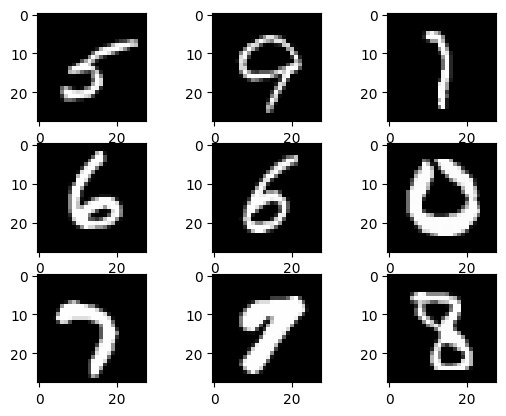

In [6]:
display_sample_images(artifacts["data_sample"])

Now that the model training job is finished. Let's retrieve the metrics and plot them.

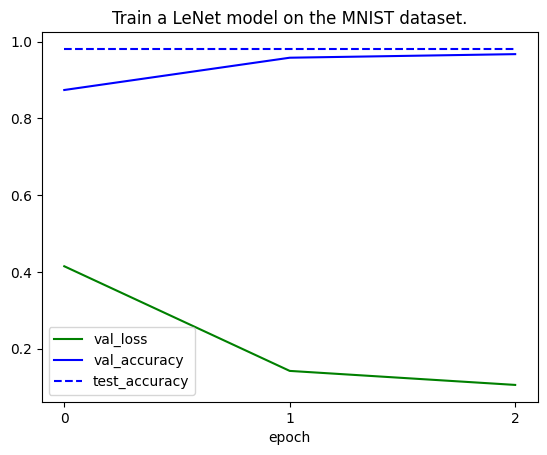

In [7]:
display_training_stats(jobs["train"])

### Generate adversarial examples using FGM attack

Next we want to understand if our model is vulnerable to an adversarial evasion attack. In evasion attacks, an adversary makes (minimal) pertubations to inference data to cause the model to misclassify the input (See [NIST AI 100-2 E2025](https://csrc.nist.gov/pubs/ai/100/2/e2025/final)). We will work with one of the earliest and simplest approaches to creating adversarial examples: the fast gradient sign method.

Note that here, we will be using the model we trained in the previous step.

In [8]:
jobs["fgm"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"Generate an adversarial dataset with the fast gradient method.",
    queue_id=queue_id,
    entrypoint_id=fgm_ep,
    values= { "dataset_name": "mnist" },
    artifact_values={ "model_artifact": artifacts["model"] },
    timeout=JOB_TIME_LIMIT,
)
jobs["fgm"] = wait_for_job(jobs["fgm"])
metrics["fgm"] = get_metrics(jobs["fgm"])
artifacts["fgm_data"] = find_artifact_by_name("adversarial_dataset", jobs["fgm"])
artifacts["fgm_sample"] = find_artifact_by_name("adversarial_dataset_sample", jobs["fgm"])

'Job finished.'

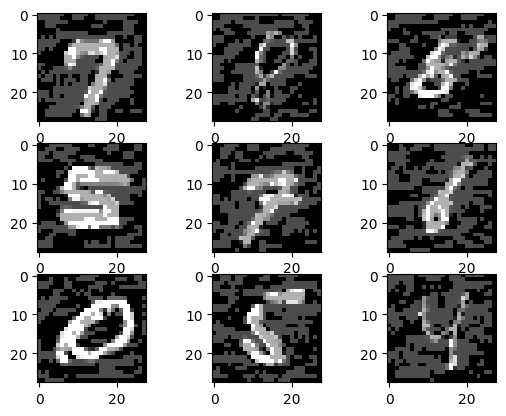

In [9]:
display_sample_images(artifacts["fgm_sample"])

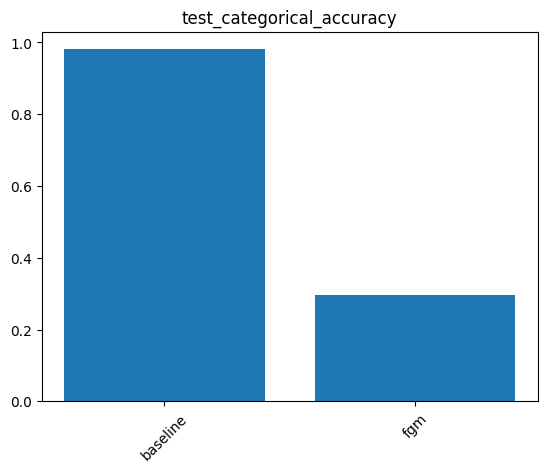

In [10]:
display_metrics(metrics, "test_categorical_accuracy")

### Generate patches based on the model and dataset

In [11]:
jobs["patch_gen"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch generation",
    queue_id=queue_id,
    entrypoint_id=patch_gen_ep,
    values={ "dataset_name": "mnist" },
    artifact_values={ "model_artifact": artifacts["model"] },
    timeout=JOB_TIME_LIMIT,
)
jobs["patch_gen"] = wait_for_job(jobs["patch_gen"])
artifacts["patch"] = find_artifact_by_name("patch,", jobs["patch_gen"])
artifacts["patch_mask"] = find_artifact_by_name("patch_mask", jobs["patch_gen"])

'Job finished.'

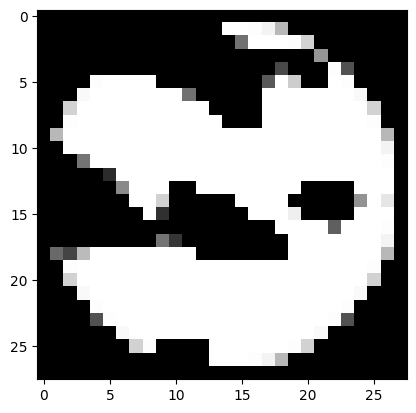

In [12]:
with TemporaryDirectory() as t:
    patch = np.load(client.artifacts.get_contents(artifacts["patch"]["id"], output_dir=t, file_stem="tmp.npy"))
    patch_mask = np.load(client.artifacts.get_contents(artifacts["patch_mask"]["id"], output_dir=t, file_stem="tmp.npy"))
ax = plt.imshow(patch * patch_mask, cmap="gray")

### Generate adversarial examples by attaching generated patches to the testing data

In [13]:
jobs["patch_apply"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch application",
    queue_id=queue_id,
    entrypoint_id=patch_apply_ep,
    values={ "dataset_name": "mnist" },
    artifact_values={
        "patch_artifact": artifacts["patch"],
        "model_artifact": artifacts["model"],
    },
    timeout=JOB_TIME_LIMIT,
)
jobs["patch_apply"] = wait_for_job(jobs["patch_apply"])
metrics["patch"] = get_metrics(jobs["patch_apply"])
artifacts["patch_data"] = find_artifact_by_name("adversarial_dataset,", jobs["patch_apply"])
artifacts["patch_data_sample"] = find_artifact_by_name("adversarial_dataset_sample", jobs["patch_apply"])

'Job finished.'

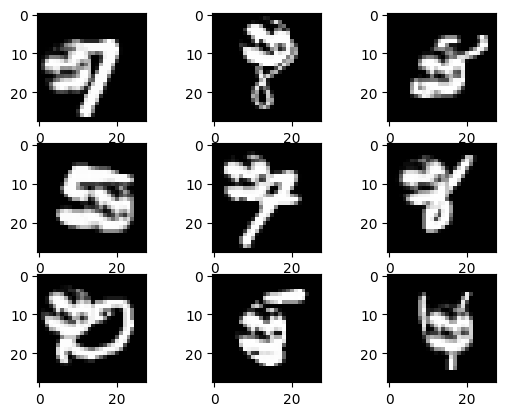

In [14]:
display_sample_images(artifacts["patch_data_sample"])

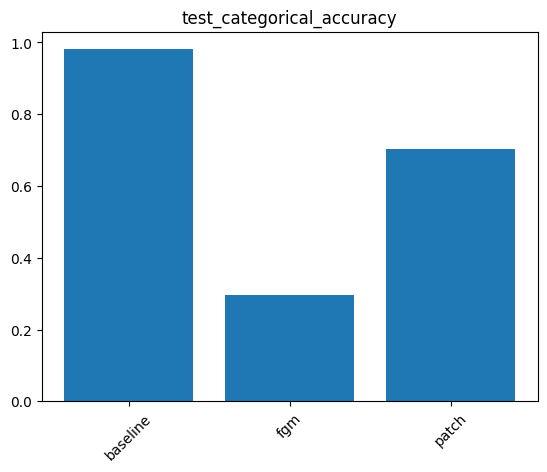

In [15]:
display_metrics(metrics, "test_categorical_accuracy")

### Base Accuracy against FGM without Defenses

In [16]:
def run_defense_job(data_artifact, model_artifact, defense_method):
    job = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=f"Apply spatial smoothing defense to FGM dataset.",
        queue_id=queue_id,
        entrypoint_id=defense_ep,
        values={ "defense_name": defense_method },
        artifact_values={
            "dataset_artifact": data_artifact,
            "model_artifact": model_artifact,
        },
        timeout=JOB_TIME_LIMIT,
    )
    return wait_for_job(job)

In [17]:
jobs["fgm_smoothing"] = run_defense_job(artifacts["fgm_data"], artifacts["model"], "spatial_smoothing")
metrics["fgm_smoothing"] = get_metrics(jobs["fgm_smoothing"])
jobs["fgm_jpeg"] = run_defense_job(artifacts["fgm_data"], artifacts["model"], "jpeg_compression")
metrics["fgm_jpeg"] = get_metrics(jobs["fgm_jpeg"])
jobs["fgm_gaussian"] = run_defense_job(artifacts["fgm_data"], artifacts["model"], "gaussian_augmentation")
metrics["fgm_gaussian"] = get_metrics(jobs["fgm_gaussian"])
jobs["patch_smoothing"] = run_defense_job(artifacts["patch_data"], artifacts["model"], "spatial_smoothing")
metrics["patch_smoothing"] = get_metrics(jobs["patch_smoothing"])
jobs["patch_jpg"] = run_defense_job(artifacts["patch_data"], artifacts["model"], "jpeg_compression")
metrics["patch_jpg"] = get_metrics(jobs["patch_jpg"])
jobs["patch_gaussian"] = run_defense_job(artifacts["patch_data"], artifacts["model"], "gaussian_augmentation")
metrics["patch_gaussian"] = get_metrics(jobs["patch_gaussian"])

'Job finished.'

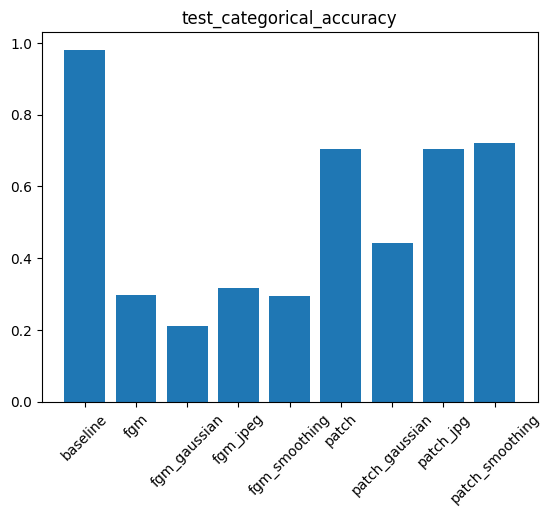

In [18]:
display_metrics(metrics, "test_categorical_accuracy")